# simulation rat behavior

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.integrate import simps
from scipy.interpolate import interp1d
import pickle
plt.style.use('./Figures/test.mplstyle')
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

from VIGOR_utils import get_block
from VIGOR_MODELS_Functions import plot_median_per_bin

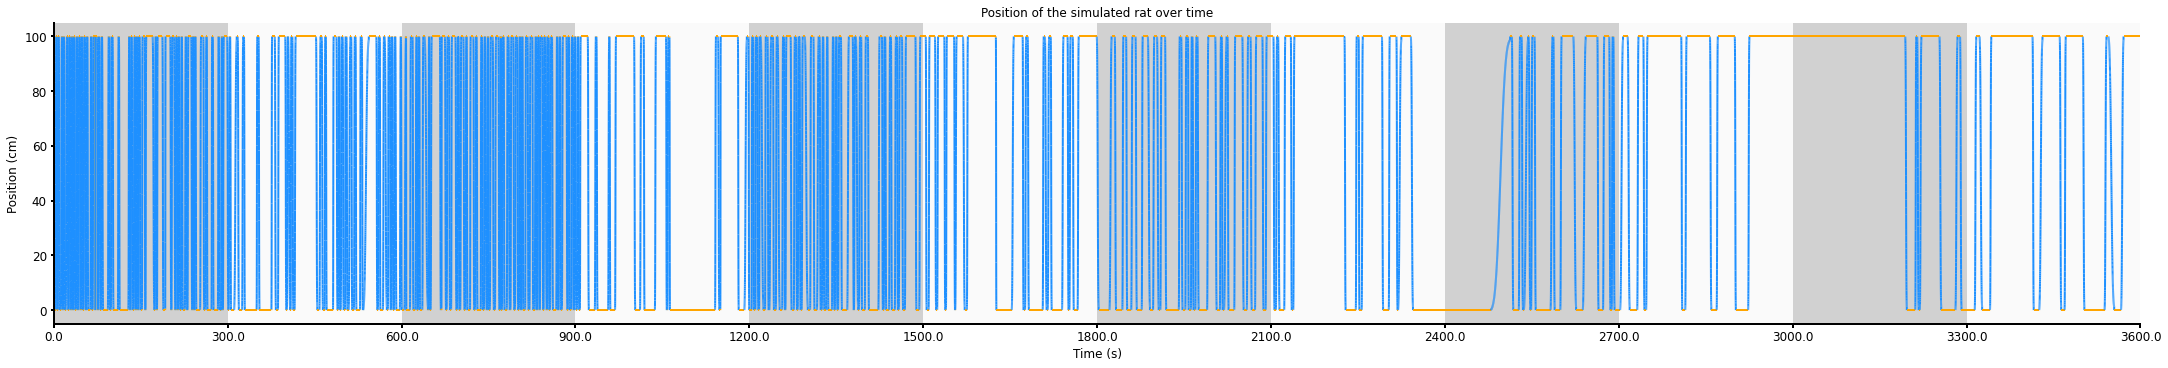

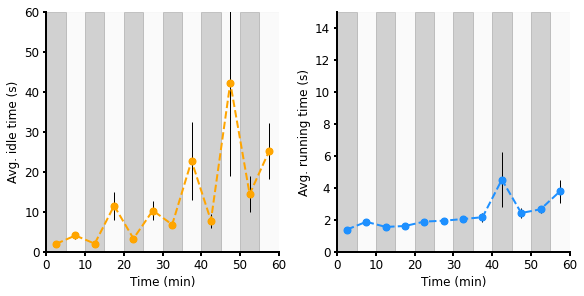

In [133]:
class Rat():
    def __init__(self, 
                 alpha=1.19, alpha_prime=0.17, alpha_second=0.01, 
                 gamma=0.66, gamma_prime=-.06, gamma_second=-.12, 
                 t0=1.37, t0_prime=0.08, t0_second=-0.02, 
                 sigma=0.09, sigma_prime=0.01, sigma_second=0.02):

        np.random.seed(15)
        self.time = 0
        self.dt = 0.04
        self.block_duration = 300
        self.session_length = 3600
        self.position_array = np.zeros(int(self.session_length / self.dt))
        self.action_array = np.ones(int(self.session_length / self.dt))
        self.test_array = np.zeros(int(self.session_length / self.dt))
        self.high_probability = 0.9
        self.low_probability = 0.1
        self.sequence = {}
        self.action_index = 0
        
        self.state = "idle"
        self.previous_run = "to_left"
        self.position_Left = 0
        self.position_Right = 100
        self.position = self.position_Left
        self.memory_size = 3
        self.memory_buffer = np.ones(self.memory_size)


        # Initialize parameters
        self.alpha = alpha
        self.alpha_prime = alpha_prime
        self.alpha_second = alpha_second
        self.gamma = gamma
        self.gamma_prime = gamma_prime
        self.gamma_second = gamma_second

        self.t0 = t0
        self.t0_prime = t0_prime
        self.t0_second = t0_second
        self.sigma = sigma
        self.sigma_prime = sigma_prime
        self.sigma_second = sigma_second

        # Initialize parameters
        self.ALPHA = self.alpha 
        self.GAMMA = self.gamma
        self.T0 = self.t0
        self.SIGMA = self.sigma

    def _reward_probability(self):
        if self.time < 0: 
            current_block = 0
        elif self.time < self.session_length: 
            current_block = self.time // self.block_duration
        else: 
            current_block = 11
        
        if current_block % 2 == 0:
            return self.high_probability
        else:
            return self.low_probability
    
    def _reward(self):
        return np.random.choice([1, 0], p=[self._reward_probability(), 1-self._reward_probability()])

    def _update_memory(self, new_reward):
        self.memory_buffer = np.roll(self.memory_buffer, -1)
        self.memory_buffer[-1] = new_reward

    def _round_nearest(self, x, a):
        return np.around(x / a) * a

    def _generate_running_time(self, _loc, _scale, N=1):
        u = np.random.uniform(0, 1, int(N))
        res = np.tan(np.pi * (u - 0.5)) * _scale + _loc
        if res < 0.5: # minimum running time is 0. seconds
            res = self._generate_running_time(_loc, _scale, N=1)
        return self._round_nearest(res, self.dt)

    def _generate_idle_time(self, alpha, gamma, N=1, maximum=500):
        def p(x, a, g): 
            return a / np.sqrt(2 * np.pi * x ** 3) * np.exp(-((a-g * x) ** 2) / (2 * x))
        def normalization(x, a, g): 
            return simps(p(x, a, g), x)
        x = np.linspace(1e-8, maximum, maximum*100)

        pdf = p(x, alpha, gamma)/normalization(x, alpha, gamma)
        cdf = np.cumsum(pdf); cdf /= max(cdf)
        u = np.random.uniform(0, 1, int(N))
        interp_function = interp1d(cdf, x)
        samples = interp_function(u)
        return self._round_nearest(samples, self.dt)
    
    def _update_p(self, parameter, parameter_prime, parameter_second):
        # parameter_prime is the slope of the parameter on the time axis (time bin 10 min), 
        # so we divide by 10*60 to get the slope per time unit
        parameter_prime /= (10*60)
        parameter_prime *= self.time

        # parameter_second is the slope of the parameter on the reward axis (reward bins 1, 0.67, .33, 0 if memory size is 3),
        # we add one parameter_second for each reward bin going from 1 to 0
        memory_average = round(np.mean(self.memory_buffer), 2)
        coef = {1:0, 0.67:1, 0.33:2, 0:3}
        parameter_second *= coef[memory_average]

        return parameter + parameter_prime + parameter_second

    def update_parameters(self):
        self.ALPHA = self._update_p(self.alpha, self.alpha_prime, self.alpha_second)
        self.GAMMA = self._update_p(self.gamma, self.gamma_prime, self.gamma_second)
        self.T0 = self._update_p(self.t0, self.t0_prime, self.t0_second)
        self.SIGMA = self._update_p(self.sigma, self.sigma_prime, self.sigma_second)

    def wait(self, idle_time):
        start_time = self.time
        while self.time <= start_time + idle_time and self.time <= self.session_length:
            self.state = "idle"
            self.position_array[int(self.time / self.dt)] = self.position
            self.action_array[int(self.time / self.dt)] = 0
            self.time += self.dt
            self.update_parameters()
        self.state = "running"

    def _position_curve(self, mu=.5, sigma=.2, N=100):
        def _bell_curve(x, mu, sigma):
            return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2) )
        x = np.linspace(0, 1, N+1)
        return np.cumsum(_bell_curve(x, mu, sigma))/N

    def _trajectory(self, start_position, end_position, running_time):
        N = int(running_time / self.dt)
        position = self._position_curve(N=N) * (end_position - start_position) + start_position
        return position

    def run(self, running_time):
        start_time = self.time
        if self.previous_run == "to_left":
            start_position = self.position_Left
            end_position = self.position_Right
        else:
            start_position = self.position_Right
            end_position = self.position_Left

        trajectory = self._trajectory(start_position, end_position, running_time)

        while self.time <= start_time + running_time and self.time <= self.session_length:
            self.state = "running"
            self.position = trajectory[int((self.time - start_time) / self.dt)]
            self.position_array[int(self.time / self.dt)] = self.position
            self.action_array[int(self.time / self.dt)] = 1
            self.time += self.dt
            self.update_parameters()

        self.position = end_position
        self.state = "idle"
        self._update_memory(self._reward())
        self.previous_run = "to_left" if self.previous_run == "to_right" else "to_right"

    def do_experiment(self):
        while self.time <= self.session_length:
            if self.state == "idle":
                idle_time = self._generate_idle_time(self.ALPHA, self.GAMMA, 1)
                self.sequence[self.action_index] = self.time, self.state, idle_time[0]
                self.wait(idle_time)
                self.action_index += 1
            elif self.state == "running":
                running_time = self._generate_running_time(self.T0, self.SIGMA, 1)
                self.sequence[self.action_index] = self.time, self.state, running_time[0]
                self.run(running_time)
                self.action_index += 1
                
        self.compute_sequence()

    def plot_trajectory(self):
        fig, ax = plt.subplots(figsize=(30, 5))

        x = np.arange(0, len(self.position_array))
        y = self.position_array
        z = self.action_array

        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=ListedColormap(['orange', 'dodgerblue']))
        lc.set_array(z)
        lc.set_linewidth(2)
        ax.add_collection(lc)

        for i in range(0, 12):
            _a = {0: 90/250, 1: 10/250}
            ax.axvspan(300*25*i, 300*25*(i+1), facecolor='grey', alpha=_a[i%2])

        ax.set_xticks(np.arange(0, len(rat.position_array)+7500, 300*25))
        ax.set_xticklabels(np.arange(0, len(rat.position_array)+7500, 300*25) * rat.dt)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Position (cm)")
        ax.set_title("Position of the simulated rat over time")
        ax.set_ylim(-5, 105)
        ax.set_xlim(0, len(rat.position_array))


    def compute_sequence(self):
        self.idle_times = {k: [] for k in range(12)}
        self.running_times = {k: [] for k in range(12)}
        for elem in self.sequence:
            if self.sequence[elem][1] == "idle":
                self.idle_times[get_block(self.sequence[elem][0])].append(self.sequence[elem][2])
            elif self.sequence[elem][1] == "running":
                self.running_times[get_block(self.sequence[elem][0])].append(self.sequence[elem][2])

    def plot_sequence(self):
        rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
        blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                    [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                    [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        plot_median_per_bin([self.idle_times[i] for i in range(0, 12)], 
                        rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 60], 
                        color=['orange'], xyLabels=["Time (min)","idle time (s)"], 
                        title="", scatter=False, stat='Avg. ', ax=axs[0]);
        axs[0].lines[0].set_linestyle("--")

        plot_median_per_bin([self.running_times[i] for i in range(0, 12)],
                        rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15],
                        color=['dodgerblue'], xyLabels=["Time (min)","running time (s)"],
                        title="", scatter=False, stat='Avg. ', ax=axs[1]);
        axs[1].lines[0].set_linestyle("--")
    
    def save_pickle(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump([self.idle_times, self.running_times], f)

# RatF02 120cm params
alpha = .97
alpha_prime = 0.24
alpha_second = 0.13
gamma = 0.55
gamma_prime = -.06
gamma_second = -.07
t0 = 1.34
t0_prime = 0.16
t0_second = -0.02
sigma = 0.11
sigma_prime = 0.03
sigma_second = 0.03

# rat = Rat()  # average rat by default
rat = Rat(alpha, alpha_prime, alpha_second, gamma, gamma_prime, gamma_second, t0, t0_prime, t0_second, sigma, sigma_prime, sigma_second)
rat.do_experiment()
rat.plot_trajectory()
rat.plot_sequence()
# rat.save_pickle(f'rat_simulations/rat_{rat.alpha_prime}_{rat.gamma_second}.p')

In [45]:
# simulations for range of parameters alpha' and gamma''

alpha = .97
alpha_prime_range = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
alpha_second = 0.01

gamma = 0.55
gamma_prime = 0.01
gamma_second_range = [0.0, -0.03, -0.06, -0.09]

t0 = 1.34
t0_prime = 0.16
t0_second = -0.02
sigma = 0.11
sigma_prime = 0.03
sigma_second = 0.03

for alpha_prime in alpha_prime_range:
    for gamma_second in gamma_second_range:
        rat = Rat(alpha, alpha_prime, alpha_second, gamma, gamma_prime, gamma_second, t0, t0_prime, t0_second, sigma, sigma_prime, sigma_second)
        rat.do_experiment()
        rat.save_pickle(f'rat_simulations/rat__{round(rat.alpha_prime, 2)}_{round(rat.gamma_second, 2)}.p')

In [48]:
%matplotlib inline
from ipywidgets import interact

def plot_sequence(alpha_prime, gamma_second):
    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    idle_times, running_times = pickle.load(open(f'rat_simulations/rat__{alpha_prime}_{gamma_second}.p', 'rb'))

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    plot_median_per_bin([idle_times[i] for i in range(0, 12)], 
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15], 
                    color=['orange'], xyLabels=["Time (min)","idle time (s)"], 
                    title="", scatter=False, stat='Avg. ', ax=axs[0]);
    axs[0].lines[0].set_linestyle("--")

    plot_median_per_bin([running_times[i] for i in range(0, 12)],
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 5],
                    color=['dodgerblue'], xyLabels=["Time (min)","running time (s)"],
                    title="", scatter=False, stat='Avg. ', ax=axs[1]);
    axs[1].lines[0].set_linestyle("--")

pl = interact(plot_sequence, alpha_prime=(0., 0.5, 0.1), gamma_second=(-0.09, 0, 0.03))

interactive(children=(FloatSlider(value=0.2, description='alpha_prime', max=0.5), FloatSlider(value=-0.06, des…

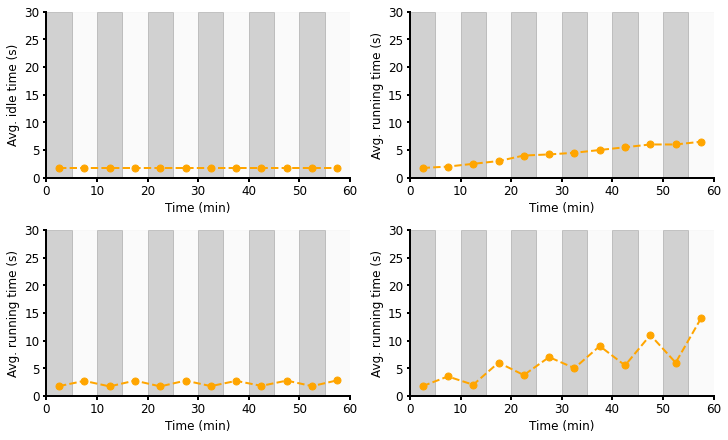

In [84]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
            [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
            [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

data1 = [1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75]
data2 = [1.75, 2, 2.5, 3, 4, 4.2, 4.5, 5, 5.5, 6, 6, 6.5]
data3 = [1.75, 2.7, 1.7, 2.75, 1.7, 2.75, 1.75, 2.7, 1.80, 2.75, 1.75, 2.80]
data4 = [1.75, 3.5, 2, 6, 3.75, 7, 5, 9, 5.5, 11, 6, 14]

plot_median_per_bin([data1[i] for i in range(0, 12)], 
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15], 
                    color=['orange'], xyLabels=["Time (min)","idle time (s)"], 
                    title="", scatter=False, stat='Avg. ', ax=axs[0, 0]);
axs[0, 0].lines[0].set_linestyle("--")


plot_median_per_bin([data2[i] for i in range(0, 12)],
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15],
                    color=['orange'], xyLabels=["Time (min)","running time (s)"],
                    title="", scatter=False, stat='Avg. ', ax=axs[0, 1]);
axs[0, 1].lines[0].set_linestyle("--")

plot_median_per_bin([data3[i] for i in range(0, 12)],
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15],
                    color=['orange'], xyLabels=["Time (min)","running time (s)"],
                    title="", scatter=False, stat='Avg. ', ax=axs[1, 0]);
axs[1, 0].lines[0].set_linestyle("--")


plot_median_per_bin([data4[i] for i in range(0, 12)],
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15],
                    color=['orange'], xyLabels=["Time (min)","running time (s)"],
                    title="", scatter=False, stat='Avg. ', ax=axs[1, 1]);
axs[1, 1].lines[0].set_linestyle("--")


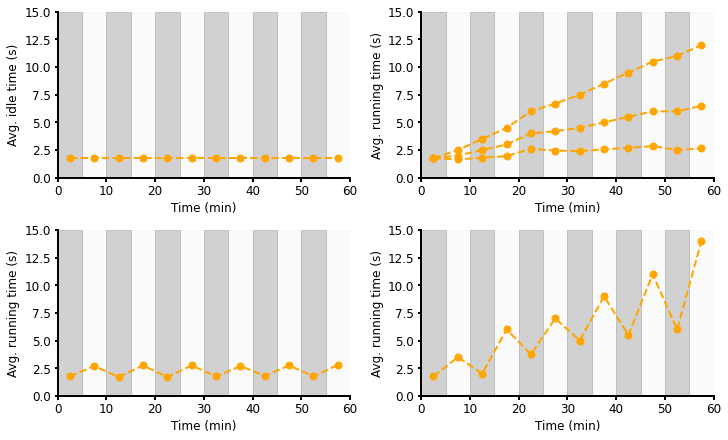

In [107]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
            [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
            [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

data1 = [1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75]
data2 = [1.75, 2, 2.5, 3, 4, 4.2, 4.5, 5, 5.5, 6, 6, 6.5]
data3 = [1.75, 2.7, 1.7, 2.75, 1.7, 2.75, 1.75, 2.7, 1.80, 2.75, 1.75, 2.80]
data4 = [1.75, 3.5, 2, 6, 3.75, 7, 5, 9, 5.5, 11, 6, 14]

plot_median_per_bin([data1[i] for i in range(0, 12)], 
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15], 
                    color=['orange'], xyLabels=["Time (min)","idle time (s)"], 
                    title="", scatter=False, stat='Avg. ', ax=axs[0, 0]);
axs[0, 0].lines[0].set_linestyle("--")


plot_median_per_bin([data2[i] for i in range(0, 12)],
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15],
                    color=['orange'], xyLabels=["Time (min)","running time (s)"],
                    title="", scatter=False, stat='Avg. ', ax=axs[0, 1]);
axs[0, 1].lines[0].set_linestyle("--")


axs[0, 1].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
        [data2[i]+(i*.5) for i in range(0, len(blocks))], 
        marker='o', ms=7, linewidth=2, color='orange', ls='--')
        
axs[0, 1].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
        [data2[i]-(i*.35) for i in range(0, len(blocks))], 
        marker='o', ms=7, linewidth=2, color='orange', ls='--')


plot_median_per_bin([data3[i] for i in range(0, 12)],
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15],
                    color=['orange'], xyLabels=["Time (min)","running time (s)"],
                    title="", scatter=False, stat='Avg. ', ax=axs[1, 0]);
axs[1, 0].lines[0].set_linestyle("--")


# data3 = [1.75, 4.7, 1.7, 4.75, 1.7, 4.75, 1.75, 4.7, 1.80, 4.75, 1.75, 4.80]
# axs[1, 0].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
#         [data3[i] for i in range(0, len(blocks))], 
#         marker='o', ms=7, linewidth=2, color='orange', ls='--')


# data3 = [1.75, 7.7, 1.7, 7.75, 1.7, 7.75, 1.75, 7.7, 1.80, 7.75, 1.75, 7.80]
# axs[1, 0].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
#         [data3[i] for i in range(0, len(blocks))], 
#         marker='o', ms=7, linewidth=2, color='orange', ls='--')


plot_median_per_bin([data4[i] for i in range(0, 12)],
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15],
                    color=['orange'], xyLabels=["Time (min)","running time (s)"],
                    title="", scatter=False, stat='Avg. ', ax=axs[1, 1]);
axs[1, 1].lines[0].set_linestyle("--")


In [89]:
def example_model_run(gain=0, modulation=0):
    test_array = np.ones(12)

    for i in range(0, 12):
        if i % 2 == 0:
            test_array[i] = test_array[i]
        else:
            test_array[i] = test_array[i] + modulation*i
        test_array[i] = test_array[i] + (gain) * i

    fig, axs = plt.subplots(1, 1, figsize=(8, 8))
    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    plot_median_per_bin([test_array[i] for i in range(0, 12)], 
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 10], 
                    color=['orange'], xyLabels=["Time (min)","idle time (s)"], 
                    title="", scatter=False, stat='Avg. ', ax=axs);
    axs.lines[0].set_linestyle("--")
    



pl = interact(example_model_run, gain=(0, .5, .1), modulation=(0, .25, .05))

interactive(children=(FloatSlider(value=0.0, description='gain', max=0.5), FloatSlider(value=0.0, description=…

In [ ]:
# RatF00 parameters idle time fit
# self.alpha = 0.74
# self.alpha_prime = 0.197
# self.alpha_second = 0.16
# self.gamma = 0.44
# self.gamma_prime = -0.04
# self.gamma_second = -0.08

# # RatF00 parameters running time fit
# self.t0 = 1.37
# self.t0_prime = 0.09
# self.t0_second = -0.0
# self.sigma = 0.11
# self.sigma_prime = 0.02
# self.sigma_second = 0.03

# # RatM01 parameters idle time fit 120
# self.alpha = 1.28
# self.alpha_prime = 0.12
# self.alpha_second = -0.03
# self.gamma = 0.79
# self.gamma_prime = -0.07
# self.gamma_second = -0.14

# # RatM01 parameters running time fit 120
# self.t0 = 1.39
# self.t0_prime = 0.06
# self.t0_second = -0.01
# self.sigma = 0.10
# self.sigma_prime = 0.0
# self.sigma_second = 0.01

In [65]:
alpha = .97
alpha_prime = 0.24
alpha_second = 0.13
gamma = 0.55
gamma_prime = -.06
gamma_second = -.07

t0_range = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5]
t0_prime_range = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25]
t0_second = -0.02
sigma = 0.11
sigma_prime = 0.03
sigma_second = 0.03

for t0 in t0_range:
    for t0_prime in t0_prime_range:
        rat = Rat(alpha, alpha_prime, alpha_second, gamma, gamma_prime, gamma_second, t0, t0_prime, t0_second, sigma, sigma_prime, sigma_second)
        rat.do_experiment()
        rat.save_pickle(f'rat_simulationsRUN/rat__{round(rat.t0, 2)}_{round(rat.t0_prime, 2)}.p')

In [66]:
%matplotlib inline
from ipywidgets import interact

def plot_sequence(t0, t0_prime):
    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    idle_times, running_times = pickle.load(open(f'rat_simulationsRUN/rat__{round(t0, 2)}_{round(t0_prime, 2)}.p', 'rb'))

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    plot_median_per_bin([idle_times[i] for i in range(0, 12)], 
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15], 
                    color=['orange'], xyLabels=["Time (min)","idle time (s)"], 
                    title="", scatter=False, stat='Avg. ', ax=axs[0]);
    axs[0].lines[0].set_linestyle("--")

    plot_median_per_bin([running_times[i] for i in range(0, 12)],
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 5],
                    color=['dodgerblue'], xyLabels=["Time (min)","running time (s)"],
                    title="", scatter=False, stat='Avg. ', ax=axs[1]);
    axs[1].lines[0].set_linestyle("--")

pl = interact(plot_sequence, t0=(0.0, 2.5, 0.5), t0_prime=(0.0, 0.25, 0.05))

interactive(children=(FloatSlider(value=1.0, description='t0', max=2.5, step=0.5), FloatSlider(value=0.1, desc…

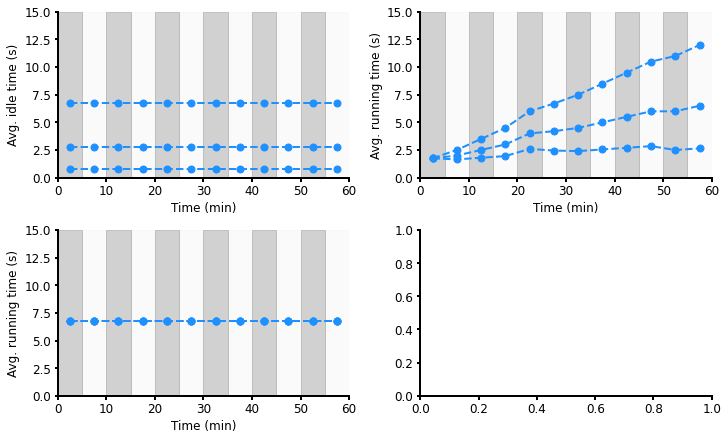

In [127]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
            [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
            [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

data1 = [1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75]
data2 = [1.75, 2, 2.5, 3, 4, 4.2, 4.5, 5, 5.5, 6, 6, 6.5]
data3 = [6.75, 6.75, 6.75, 6.75, 6.75, 6.75, 6.75, 6.75, 6.75, 6.75, 6.75, 6.75]
data4 = [6.75, 7, 7.5, 8, 9, 9.2, 9.5, 10, 10.5, 11, 11, 11.5]

plot_median_per_bin([data1[i]+1 for i in range(0, 12)], 
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15], 
                    color=['dodgerblue'], xyLabels=["Time (min)","idle time (s)"], 
                    title="", scatter=False, stat='Avg. ', ax=axs[0, 0]);
axs[0, 0].lines[0].set_linestyle("--")


axs[0, 0].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
        [data1[i]+5 for i in range(0, len(blocks))], 
        marker='o', ms=7, linewidth=2, color='dodgerblue', ls='--')
        
axs[0, 0].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
        [data1[i]-1 for i in range(0, len(blocks))], 
        marker='o', ms=7, linewidth=2, color='dodgerblue', ls='--')



plot_median_per_bin([data2[i] for i in range(0, 12)],
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15],
                    color=['dodgerblue'], xyLabels=["Time (min)","running time (s)"],
                    title="", scatter=False, stat='Avg. ', ax=axs[0, 1]);
axs[0, 1].lines[0].set_linestyle("--")


axs[0, 1].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
        [data2[i]+(i*.5) for i in range(0, len(blocks))], 
        marker='o', ms=7, linewidth=2, color='dodgerblue', ls='--')
        
axs[0, 1].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
        [data2[i]-(i*.35) for i in range(0, len(blocks))], 
        marker='o', ms=7, linewidth=2, color='dodgerblue', ls='--')


        

plot_median_per_bin([data3[i] for i in range(0, 12)],
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15],
                    color=['dodgerblue'], xyLabels=["Time (min)","running time (s)"],
                    title="", scatter=False, stat='Avg. ', ax=axs[1, 0]);
axs[1, 0].lines[0].set_linestyle("--")

axs[1, 0].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
        [data3[i] for i in range(0, len(blocks))], 
        marker='o', ms=7, linewidth=2, color='dodgerblue', ls='--')
        
axs[1, 0].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
        [data3[i] for i in range(0, len(blocks))], 
        marker='o', ms=7, linewidth=2, color='dodgerblue', ls='--')


# plot_median_per_bin([data4[i] for i in range(0, 12)],
#                     rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15],
#                     color=['dodgerblue'], xyLabels=["Time (min)","running time (s)"],
#                     title="", scatter=False, stat='Avg. ', ax=axs[1, 1]);
# axs[1, 1].lines[0].set_linestyle("--")


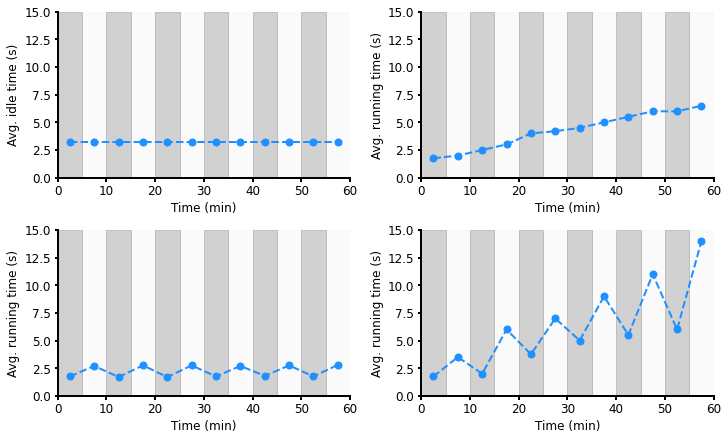

In [132]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
            [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
            [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

data1 = [1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75]
data2 = [1.75, 2, 2.5, 3, 4, 4.2, 4.5, 5, 5.5, 6, 6, 6.5]
data3 = [1.75, 2.7, 1.7, 2.75, 1.7, 2.75, 1.75, 2.7, 1.80, 2.75, 1.75, 2.80]
data4 = [1.75, 3.5, 2, 6, 3.75, 7, 5, 9, 5.5, 11, 6, 14]

plot_median_per_bin([data1[i]+1.5 for i in range(0, 12)], 
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15], 
                    color=['dodgerblue'], xyLabels=["Time (min)","idle time (s)"], 
                    title="", scatter=False, stat='Avg. ', ax=axs[0, 0]);
axs[0, 0].lines[0].set_linestyle("--")


plot_median_per_bin([data2[i] for i in range(0, 12)],
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15],
                    color=['dodgerblue'], xyLabels=["Time (min)","running time (s)"],
                    title="", scatter=False, stat='Avg. ', ax=axs[0, 1]);
axs[0, 1].lines[0].set_linestyle("--")

plot_median_per_bin([data3[i] for i in range(0, 12)],
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15],
                    color=['dodgerblue'], xyLabels=["Time (min)","running time (s)"],
                    title="", scatter=False, stat='Avg. ', ax=axs[1, 0]);
axs[1, 0].lines[0].set_linestyle("--")


plot_median_per_bin([data4[i] for i in range(0, 12)],
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15],
                    color=['dodgerblue'], xyLabels=["Time (min)","running time (s)"],
                    title="", scatter=False, stat='Avg. ', ax=axs[1, 1]);
axs[1, 1].lines[0].set_linestyle("--")


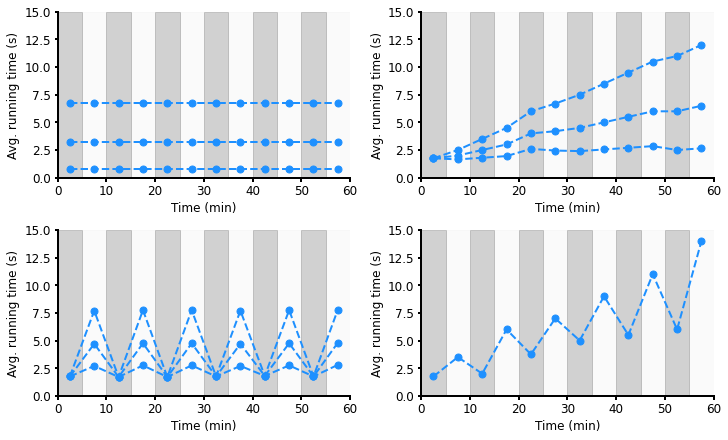

In [131]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
            [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
            [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

data1 = [1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75]
data2 = [1.75, 2, 2.5, 3, 4, 4.2, 4.5, 5, 5.5, 6, 6, 6.5]
data3 = [1.75, 2.7, 1.7, 2.75, 1.7, 2.75, 1.75, 2.7, 1.80, 2.75, 1.75, 2.80]
data4 = [1.75, 3.5, 2, 6, 3.75, 7, 5, 9, 5.5, 11, 6, 14]

plot_median_per_bin([data1[i]+1.5 for i in range(0, 12)], 
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15], 
                    color=['dodgerblue'], xyLabels=["Time (min)","running time (s)"], 
                    title="", scatter=False, stat='Avg. ', ax=axs[0, 0]);
axs[0, 0].lines[0].set_linestyle("--")

axs[0, 0].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
        [data1[i]+5 for i in range(0, len(blocks))], 
        marker='o', ms=7, linewidth=2, color='dodgerblue', ls='--')
        
axs[0, 0].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
        [data1[i]-1 for i in range(0, len(blocks))], 
        marker='o', ms=7, linewidth=2, color='dodgerblue', ls='--')


plot_median_per_bin([data2[i] for i in range(0, 12)],
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15],
                    color=['dodgerblue'], xyLabels=["Time (min)","running time (s)"],
                    title="", scatter=False, stat='Avg. ', ax=axs[0, 1]);
axs[0, 1].lines[0].set_linestyle("--")


axs[0, 1].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
        [data2[i]+(i*.5) for i in range(0, len(blocks))], 
        marker='o', ms=7, linewidth=2, color='dodgerblue', ls='--')
        
axs[0, 1].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
        [data2[i]-(i*.35) for i in range(0, len(blocks))], 
        marker='o', ms=7, linewidth=2, color='dodgerblue', ls='--')


plot_median_per_bin([data3[i] for i in range(0, 12)],
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15],
                    color=['dodgerblue'], xyLabels=["Time (min)","running time (s)"],
                    title="", scatter=False, stat='Avg. ', ax=axs[1, 0]);
axs[1, 0].lines[0].set_linestyle("--")


data3 = [1.75, 4.7, 1.7, 4.75, 1.7, 4.75, 1.75, 4.7, 1.80, 4.75, 1.75, 4.80]
axs[1, 0].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
        [data3[i] for i in range(0, len(blocks))], 
        marker='o', ms=7, linewidth=2, color='dodgerblue', ls='--')


data3 = [1.75, 7.7, 1.7, 7.75, 1.7, 7.75, 1.75, 7.7, 1.80, 7.75, 1.75, 7.80]
axs[1, 0].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
        [data3[i] for i in range(0, len(blocks))], 
        marker='o', ms=7, linewidth=2, color='dodgerblue', ls='--')


plot_median_per_bin([data4[i] for i in range(0, 12)],
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15],
                    color=['dodgerblue'], xyLabels=["Time (min)","running time (s)"],
                    title="", scatter=False, stat='Avg. ', ax=axs[1, 1]);
axs[1, 1].lines[0].set_linestyle("--")
